# Image generation of MNIST via β-VAE

## Table of contents

1. Implementation of β-VAE
  - 1.1. Loading MNIST dataset
  - 1.2. Theory
  - 1.3. Implementation
  - 1.4. Training
2. Visalization of reconstructed image
  - 2.1. Original image
  - 2.2. Reconstructed image
3. Random sampling from latent variable
4. Plotting in latent space
5. Visualization of manifolds in latent space 

In [76]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64
n_epochs = 15
beta = 2
z_dim = 10
assert z_dim >= 2

## 1. Implementation of β-VAE

### 1.1. Loading MNIST dataset

In [64]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))])

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

### 1.2. Theory

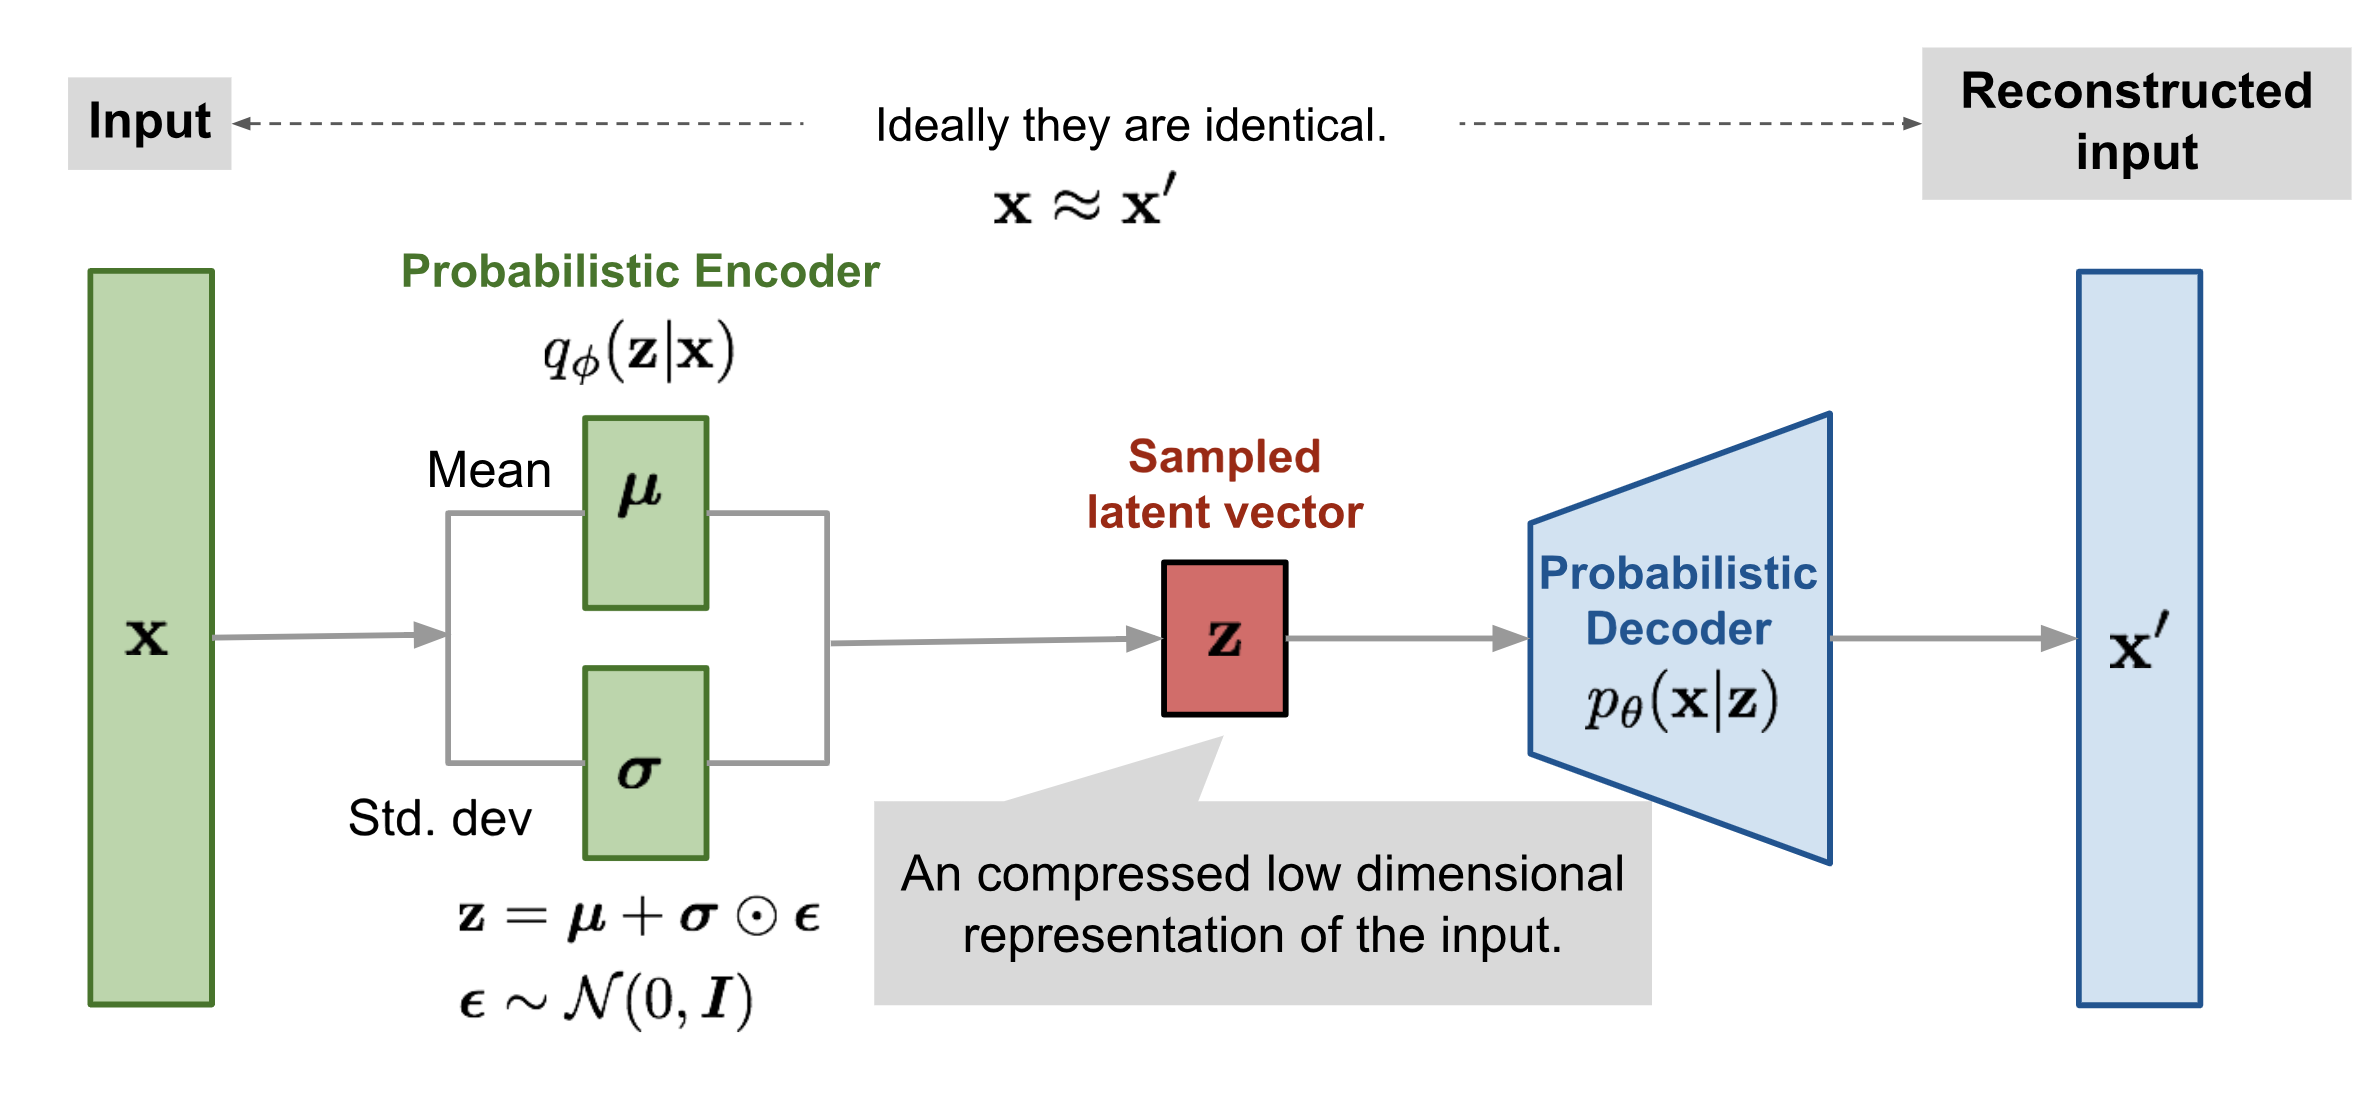

**Encoder and decoder of VAE are decoded as follows.**
- Encoder (Gaussian distribution)：$$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| \mu,\sigma^2{\bf I}), 　s.t.　\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x}). $$
- Decoder (Bernoulli distribution)：$$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}| \lambda), 　s.t.　\lambda=f_{\theta}({\bf z}).$$
<br>

**ELBO (Evidence Lower BOund) is represented like below.**  The first and the second term are corresponding to (minus) reconstruction loss and KL divergence, respectively. For the implementation of β-VAE, the coefficient β(>1) in the regularisation term of the objective function is needed in order to make the model more disentangled.


$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -\beta D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]
 $$  

The first term of the objective function can be sample approximated as follows.
$$
  \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]\simeq \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)}),  　s.t.　{\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})
$$

Note that since the decoder is a Bernoulli distribution, the right-hand side of the above equation can be calculated as follows.

$$
  \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D (x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)),　s.t.　\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})
$$


For the second term of the objective function, it can be calculated analytically as follows.（[KL divergence between normal distributions](https://leenashekhar.github.io/2019-01-30-KL-Divergence/)）
$$
  D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2), 　s.t.　p_{\theta}({\bf z})={\cal N}(0,{\bf I})
$$

### 1.3. Implementation

In [65]:
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# Model definition of BetaVAE
class BetaVAE(nn.Module):
    def __init__(self, z_dim=10, nc=1):
        super(BetaVAE, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        # Encoder
        self.enc_conv1 = nn.Conv2d(nc, 8, 3, 2, 1)               # B, 8, 14, 14
        self.enc_conv2 = nn.Conv2d(8, 16, 3, 2, 1)               # B, 16, 7, 7
        self.enc_conv3 = nn.Conv2d(16, 32, 3, 2)                 # B, 32, 3, 3
        self.enc_fc1 = nn.Linear(32*3*3, 128)                    # B, 128
        self.enc_mean = nn.Linear(128, z_dim)                    # B, z_dim
        self.enc_std = nn.Linear(128, z_dim)                     # B, z_dim
        # Decoder
        self.dec_fc1 = nn.Linear(z_dim, 128)                     # B, 128
        self.dec_fc2 = nn.Linear(128, 32*3*3)                    # B, 32*3*3
        self.dec_convt1 = nn.ConvTranspose2d(32, 16, 3, 2)       # B, 16, 7, 7
        self.dec_convt2 = nn.ConvTranspose2d(16, 8, 3, 2, 1, 1)  # B, 8, 14, 14
        self.dec_convt3 = nn.ConvTranspose2d(8, nc, 3, 2, 1, 1)  # B, 1, 28, 28
        # BN
        self.bn = nn.BatchNorm2d(16)

    
    def _encoder(self, x):
        x = F.relu(self.enc_conv1(x.view(-1, self.nc, 28, 28)))
        x = F.relu(self.enc_conv2(x))
        x = self.bn(x)
        x = F.relu(self.enc_conv3(x))
        x = F.relu(self.enc_fc1(x.view(-1, 32*3*3)))
        mean = self.enc_mean(x)
        std = F.softplus(self.enc_std(x))
        return mean, std
    
    def _sample_z(self, mean, std):
        # Reparametrization trick
        epsilon = torch.randn(mean.shape).to(device)
        return mean + std * epsilon
 
    def _decoder(self, z):
        x = F.relu(self.dec_fc1(z))
        x = F.relu(self.dec_fc2(x))
        x = F.relu(self.dec_convt1(x.view(-1, 32, 3, 3)))
        x = self.bn(x)
        x = F.relu(self.dec_convt2(x))
        x = self.dec_convt3(x)
        # Using sigmoid function so that the output should be in [0,1]
        x = torch.sigmoid(x.view(-1, self.nc*28*28))
        return x

    def forward(self, x):
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, std = self._encoder(x)
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
    
        z = self._sample_z(mean, std)
        y = self._decoder(z)

        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))
        
        return KL, -reconstruction 

### 1.4. Training

In [77]:
model = BetaVAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        model.zero_grad()

        # KL_loss, reconstruction_loss, and ELBO
        KL_loss, reconstruction_loss = model.loss(x)  
        loss = reconstruction_loss + beta*KL_loss 

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x, t in dataloader_valid:

        x = x.to(device)

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH: 1    Train Lower Bound: 195.201599 (KL_loss: 6.208970. reconstruction_loss: 182.783646)    Valid Lower Bound: 157.972519
EPOCH: 2    Train Lower Bound: 140.694107 (KL_loss: 10.345242. reconstruction_loss: 120.003632)    Valid Lower Bound: 147.554184
EPOCH: 3    Train Lower Bound: 134.423904 (KL_loss: 11.350098. reconstruction_loss: 111.723709)    Valid Lower Bound: 142.502487
EPOCH: 4    Train Lower Bound: 131.724915 (KL_loss: 11.685005. reconstruction_loss: 108.354912)    Valid Lower Bound: 145.885117
EPOCH: 5    Train Lower Bound: 130.017334 (KL_loss: 11.886742. reconstruction_loss: 106.243851)    Valid Lower Bound: 149.103683
EPOCH: 6    Train Lower Bound: 128.831009 (KL_loss: 12.025841. reconstruction_loss: 104.779335)    Valid Lower Bound: 145.622818
EPOCH: 7    Train Lower Bound: 127.923172 (KL_loss: 12.149063. reconstruction_loss: 103.625053)    Valid Lower Bound: 146.172440
EPOCH: 8    Train Lower Bound: 127.217049 (KL_loss: 12.232049. reconstruction_loss: 102.752945)   

## 2. Visualization of reconstructed image

### 2.1. Original image

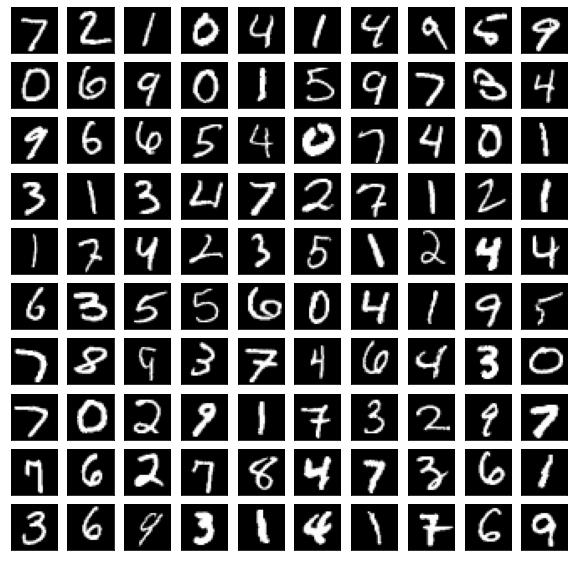

In [67]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### 2.2. Reconstructed image

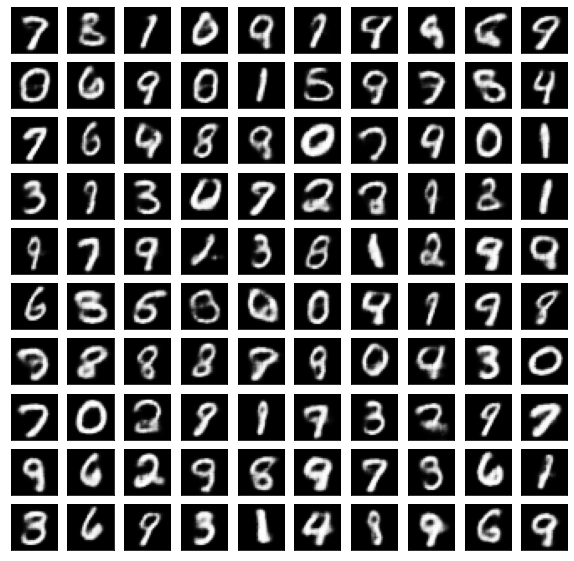

In [78]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 3. Random sampling from latent variable

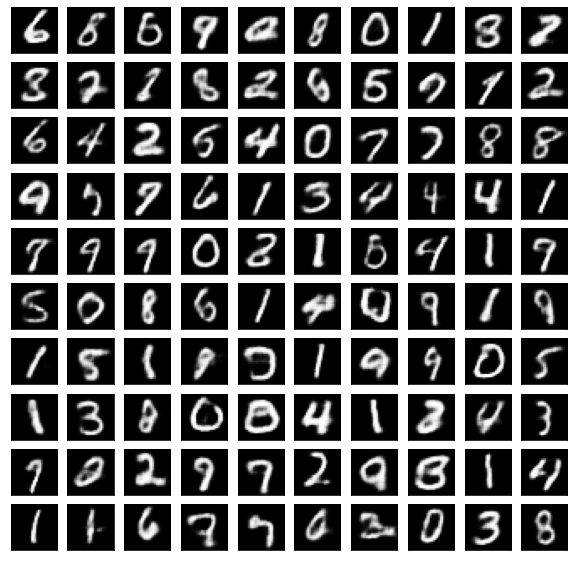

In [79]:
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    z = torch.randn([1, z_dim]).to(device)
    y = model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 4. Plotting in latent space

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


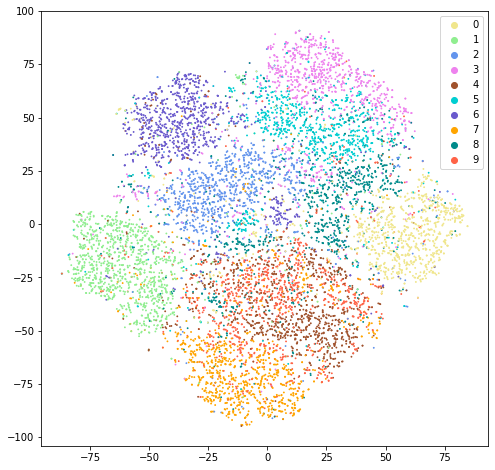

In [80]:
dim_red = 'TSNE' # 'TSNE' or 'PCA'

valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
model.eval()
t_list = []; z_list = []
for x, t in valid_dataset:
    t_list.append(t)
    x = x.to(device).unsqueeze(0)
    y, z = model(x)
    z_list.append(z.cpu().detach().numpy()[0])

if z_dim == 2:
    z_list = np.array(z_list).T
else:
    if dim_red == 'TSNE':
        from sklearn.manifold import TSNE
        z_list = TSNE(n_components=2).fit_transform(z_list).T
    elif dim_red == 'PCA':
        from sklearn.decomposition import PCA
        z_list = PCA(n_components=2).fit(np.array(z_list).T).components_
    else:
        raise ValueError()

colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna', 'darkturquoise', 'slateblue', 'orange',
                        'darkcyan', 'tomato']
plt.figure(figsize=(8,8))
plt.scatter(z_list[0], z_list[1], s=0.7, c=[colors[t] for t in t_list])

# add legend
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()

## 5. Visualization of manifolds in latent space

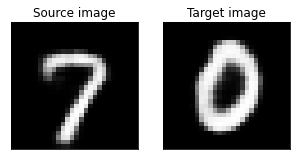

In [81]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(5, 5))
model.eval()

x0, t = valid_dataset[0]
x0 = x0.to(device)
x0 = x0.unsqueeze(0)
y0, z0 = model(x0)
im = y0.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax0.set_title('Source image')
ax0.imshow(im, 'gray')

x1, t = valid_dataset[3]
x1 = x1.to(device)
x1 = x1.unsqueeze(0)
y1, z1 = model(x1)
im = y1.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Target image')
ax1.imshow(im, 'gray')

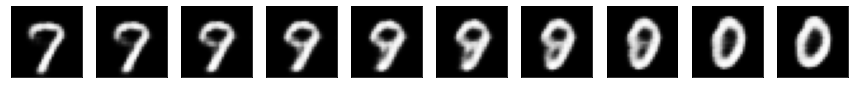

In [82]:
fig = plt.figure(figsize=(15, 15))
z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)])
z_linear = z_linear.view((10, -1))
y2 = model._decoder(z_linear).view(-1, 28, 28)
for i, im in enumerate(y2.cpu().detach().numpy()):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')
fig.savefig("manifolds.png")